In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

for encoding in ['utf-8', 'latin-1', 'ISO-8859-1', 'cp1252']:
    try:
        df = pd.read_csv('db.csv', encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

df = df[df['Category'] == 'Social Life']
df['Date'] = range(1, len(df) + 1)
time, series = df['Date'].values, df['Amount'].values
df.head()


,Date,Amount,Category
0,1,38.1,Social Life
4,2,32.4,Social Life
7,3,34.5,Social Life
10,4,20.7,Social Life
15,5,21.5,Social Life


In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

time, series = time[:1500], series[:1500]
split_time= int(0.9 * len(series))

time_train= time[:split_time]
x_train= series[:split_time]
time_valid= time[split_time:]
x_valid= series[split_time:]

window_size= 32
batch_size= 32
shuffle_buffer_size= 500

train_set=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 3:
            self.model.stop_training = True

callbacks = myCallback()

model=tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=[None, 1], return_sequences=True,),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(60, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])

model.compile(loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=["mae"],
                run_eagerly=True)

history = model.fit(train_set, epochs=5, callbacks=[callbacks])

Epoch 1/5
42/42 [==============================] - 15s 361ms/step - loss: 10.5871 - mae: 11.0745
Epoch 2/5
42/42 [==============================] - 15s 352ms/step - loss: 3.9136 - mae: 4.3856
Epoch 3/5
42/42 [==============================] - 14s 331ms/step - loss: 3.8395 - mae: 4.3104
Epoch 4/5
42/42 [==============================] - 14s 332ms/step - loss: 3.6250 - mae: 4.0944
Epoch 5/5
42/42 [==============================] - 12s 295ms/step - loss: 3.4784 - mae: 3.9459


5/5 [==============================] - 1s 160ms/step


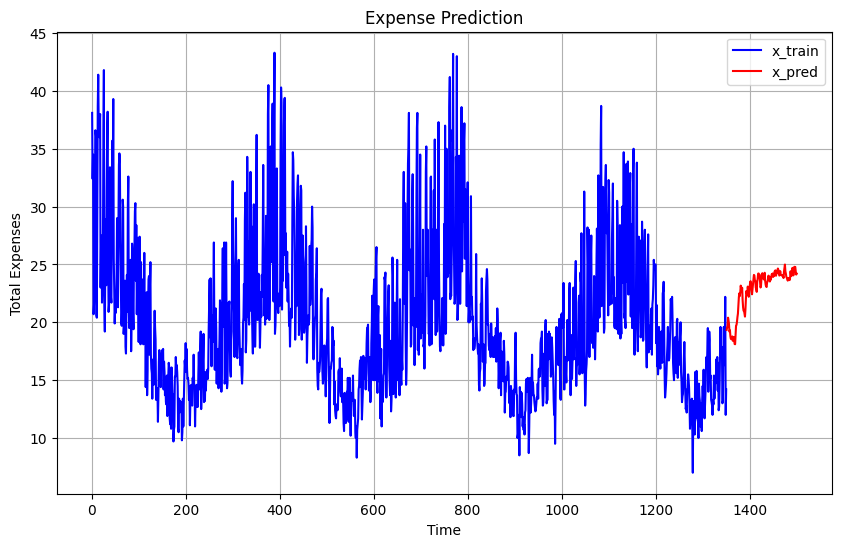

In [5]:
def create_input_sequences_for_prediction(x_train, x_valid, split_time, window_size):
    input_sequences = []
    for j in range(len(x_train) - window_size, split_time + len(x_valid) - window_size):
        input_sequences.append(series[j:j+window_size])
    return np.array(input_sequences)

# Generate input sequences for prediction for x_valid
input_sequences_x_valid = create_input_sequences_for_prediction(x_train, x_valid, split_time, window_size)


# Make predictions for x_valid
predictions_x_valid = model.predict(input_sequences_x_valid)

# Plot the original data and predictions
plt.figure(figsize=(10, 6))
plt.plot(time_train, x_train, label='x_train', color='blue')
plt.plot(time_valid, predictions_x_valid, label='x_pred', color='red')
plt.xlabel('Time')
plt.ylabel('Total Expenses')
plt.title('Expense Prediction')
plt.legend()
plt.grid(True)
plt.show()
